## 1. Import Libraries

In [14]:
import netrc
import requests
from requests.auth import HTTPBasicAuth
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import earthaccess
%matplotlib inline

## 2. Store the Token Endpoint URLs 

In [2]:
# Setup the signin and time series URLs
signin_url = "https://api.giovanni.earthdata.nasa.gov/signin"
time_series_url = "https://api.giovanni.earthdata.nasa.gov/proxy-timeseries"


## 3. Store Parameters

Look at 20 years of 3-hourly temperature data over 45.125N,98.125W, which is in Benton Township, South Dakota.

In [10]:
lat = 38.60327
lon = -90.26047
time_start = "1980-01-01T00:00:00"
time_end = "2004-12-31T23:00:00"
data = "NLDAS_FORA0125_H_2_0_Tair"

## 4. Retrieve Token

We will use the Earthdata Login credentials stored in our local `netrc` file to retrieve a token. The token is valid for 24 hours, so we can actually use the same token repeatedly.

In [4]:
token = requests.get(signin_url, auth=HTTPBasicAuth(netrc.netrc().hosts['urs.earthdata.nasa.gov'][0], 
                                                    netrc.netrc().hosts['urs.earthdata.nasa.gov'][2]),
                     allow_redirects=True).text.replace('"','')


## 5. Define a Function That Calls the Time Series Service

In [5]:
def call_time_series(lat,lon,time_start,time_end,data):
    """
    INPUTS:
    lat - latitude
    lon - longitude
    time_start - start of time series in YYYY-MM-DDThh:mm:ss format (UTC)
    end_time - end of the time series in YYYY-MM-DDThh:mm:ss format (UTC)
    data - name of the data parameter for the time series
    
    OUTPUT:
    time series csv output string
    """
    query_parameters = {
        "data":data,
        "location":"[{},{}]".format(lat,lon),
        "time":"{}/{}".format(time_start,time_end)
    }
    headers = {"authorizationtoken":token}
    response=requests.get(time_series_url,params=query_parameters,headers=headers)
    print(response)
    return response.text


## 6. Define a Function That Parses the Response From the Time Series Service

This will return the headers from the CSV as a Python dictionary, and the values formatted as a Pandas dataframe.

In [6]:
def parse_csv(ts):
    """
    INPUTS:
    ts - time series output of the time series service
    
    OUTPUTS:
    headers,df - the headers from the CSV as a dict and the values in a pandas dataframe
    """
    with io.StringIO(ts) as f:
        # the first 13 rows are header
        headers = {}
        for i in range(13):
            line = f.readline()
            key,value = line.split(",")
            headers[key] = value.strip()

        # Read the csv proper
        df = pandas.read_csv(
            f,
            header=1,
            names=("Timestamp",headers["param_name"]),
            converters={"Timestamp":pandas.Timestamp}
        )

    return headers, df

## 7. Call the Time Series Service

The response will be stored in a variable called `df`.

In [ ]:
%%time

ts = call_time_series(lat,lon,time_start,time_end,data)


<Response [200]>
CPU times: total: 0 ns
Wall time: 9.66 s


## 8. Parse the output

In [79]:
headers,df = parse_csv(ts)
print(df.head())

            Timestamp  2-meter above ground Temperature
0 1980-01-01 00:00:00                            276.71
1 1980-01-01 01:00:00                            276.42
2 1980-01-01 02:00:00                            276.14
3 1980-01-01 03:00:00                            275.86
4 1980-01-01 04:00:00                            275.41


In [90]:
df.index = pd.to_datetime(df['Timestamp'])  # Ensure the index is datetime
df.index = df.index.tz_localize('UTC')  # Localize to UTC
df.index = df.index.tz_convert('America/Chicago')  # Convert to St. Louis local time (CST/CDT)

# Resample data by day to calculate daily max and min temperatures
daily_temps = df.resample('D').agg({'2-meter above ground Temperature': ['max', 'min']})

# Reset column names for easier access
daily_temps.columns = ['daily_max', 'daily_min']

daily_temps

,daily_max,daily_min
Timestamp,,
1979-12-31 00:00:00-06:00,276.71,274.95
1980-01-01 00:00:00-06:00,280.51,271.07
1980-01-02 00:00:00-06:00,279.78,271.62
1980-01-03 00:00:00-06:00,275.12,271.45
1980-01-04 00:00:00-06:00,273.37,270.42
...,...,...
2004-12-27 00:00:00-06:00,273.63,266.53
2004-12-28 00:00:00-06:00,278.39,270.15
2004-12-29 00:00:00-06:00,287.58,276.81


In [91]:
daily_temps['day_of_year'] = daily_temps.index.strftime('%m-%d')

# Group by day_of_year and calculate the mean for daily_max and daily_min
mean_temps = daily_temps.groupby('day_of_year')[['daily_max', 'daily_min']].mean()

# Reset index for clarity (optional)
mean_temps = mean_temps.reset_index()

# Convert daily_max and daily_min to Fahrenheit
mean_temps['daily_max'] = (mean_temps['daily_max'] - 273.15) * 9/5 + 32
mean_temps['daily_min'] = (mean_temps['daily_min'] - 273.15) * 9/5 + 32

mean_temps

,day_of_year,daily_max,daily_min
0,01-01,38.410880,24.242720
1,01-02,39.180560,26.619440
2,01-03,38.544800,25.155680
3,01-04,36.316400,22.321040
4,01-05,35.997440,21.976160
...,...,...,...
361,12-27,39.210080,25.993040
362,12-28,40.422560,26.105360
363,12-29,39.174080,24.843920
364,12-30,40.188560,25.586960


<Axes: >

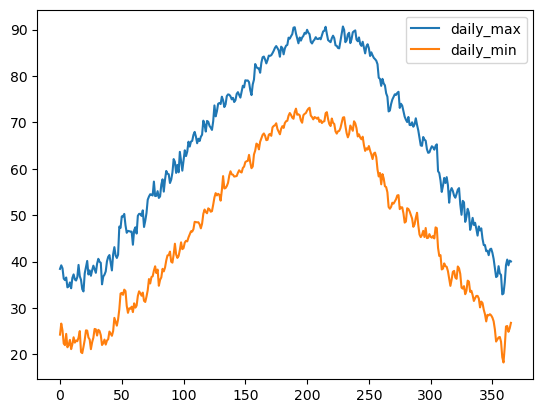

In [87]:
mean_temps.plot()

In [102]:
# Add a column for day_of_year
daily_temps['day_of_year'] = daily_temps.index.strftime('%m-%d')

# Group by day_of_year and calculate standard deviations
daily_std = daily_temps.groupby('day_of_year')[['daily_max', 'daily_min']].std()

# Reset index for clarity (optional)
daily_std = daily_std.reset_index()

# Rename columns for clarity
daily_std.rename(columns={'daily_max': 'std_max', 'daily_min': 'std_min'}, inplace=True)

# Display the results
print(daily_std)



    day_of_year   std_max   std_min
0         01-01  6.349539  3.945385
1         01-02  7.156515  6.165334
2         01-03  7.488479  6.723813
3         01-04  7.298869  7.148159
4         01-05  5.125908  6.856522
..          ...       ...       ...
361       12-27  5.144732  3.861434
362       12-28  6.285094  5.753808
363       12-29  6.788630  6.049966
364       12-30  7.470181  7.752311
365       12-31  5.925115  5.898162

[366 rows x 3 columns]


In [103]:
daily_std.to_csv('daily_tmax_tmin_stdev.csv')